In [1]:
import pandas as pd
# For more information, visit https://pandas.pydata.org/

import numpy as np
# For more information, visit https://numpy.org/

import re
# For more information, visit https://docs.python.org/3/library/re.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
#For more information, visit https://scikit-learn.org/stable/

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#For more informaton, visit https://www.tensorflow.org/

import matplotlib.pyplot as plt
#For more information, visit https://matplotlib.org/

import seaborn as sns
#For more information, visit https://seaborn.pydata.org/

sns.set_palette("Set2")

In [71]:
# Load and display training data
train = pd.read_csv('../Data/Input/train.csv')
print('Training data shape:', train.shape)
train.head()

Training data shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [72]:
# Load and display testing data
test = pd.read_csv('../Data/Input/test.csv')
print('Testing data shape:', test.shape)
test.head()

Testing data shape: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [73]:
# Check missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [74]:
# Check missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### The ratio of missing values in test and training sets are around the same, we can assume that they were taken from the same sample

In [75]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


### The location column has too many missing and unique values, so I won't use it as a feature

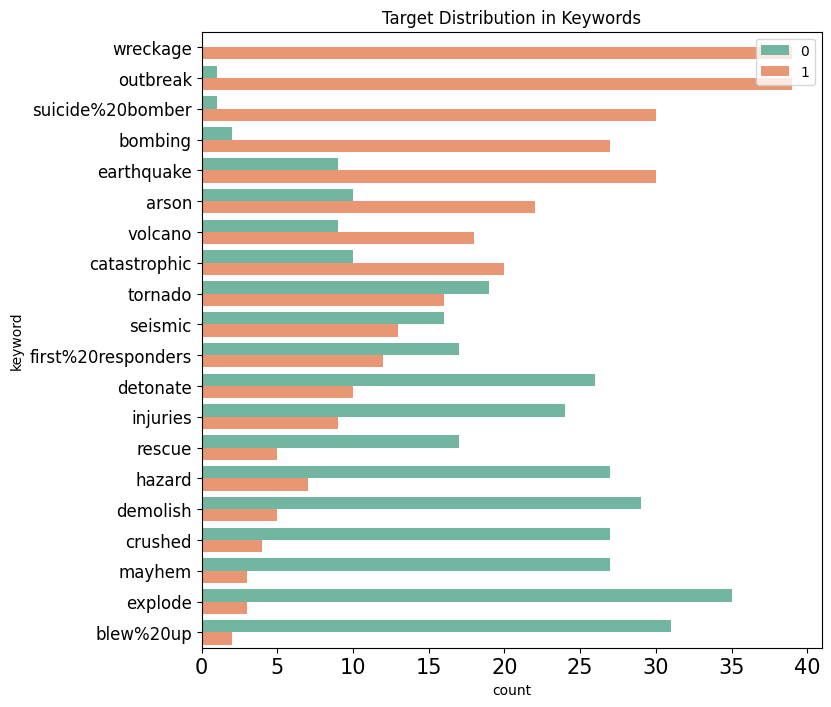

In [76]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

# Get 20 evenly distributed keywords
num_keywords = 20
unique_keywords = train['keyword'].unique()
step = len(unique_keywords) // num_keywords
selected_keywords = unique_keywords[::step]

filtered_train = train[train['keyword'].isin(selected_keywords)]

fig = plt.figure(figsize=(8, 8), dpi=100)

sns.countplot(y=filtered_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=filtered_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)


### The keyword column can be quite misleading. For example I would assume that the keywords 'explode', 'rescue' and 'crushed' are related to a disaster. However, by looking at the plot we can see that the tweets with these keywords were mostly labeled as non-disaster related. For now I wont use it as a feature

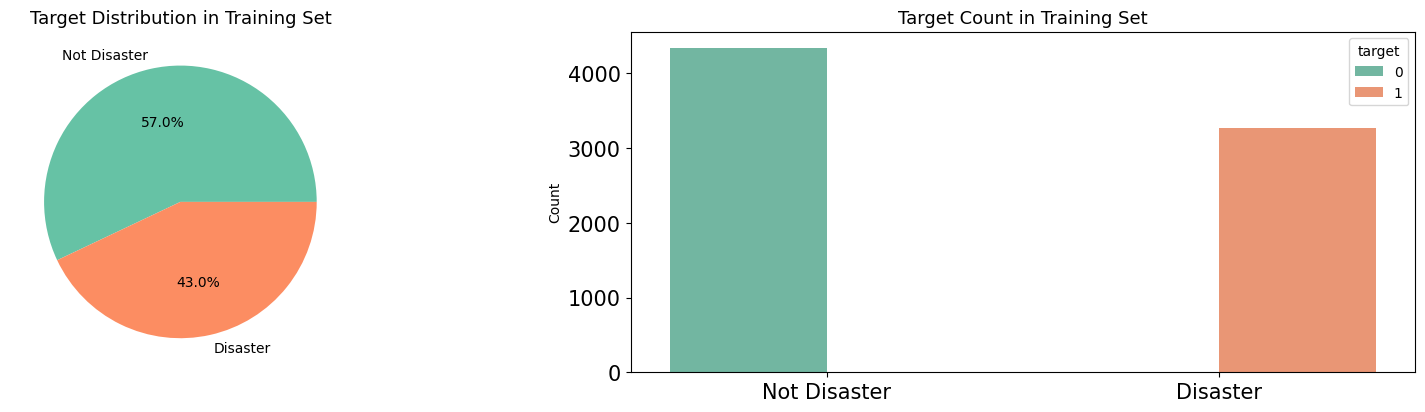

In [77]:
# Visualize target distribution
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train['target'].value_counts().plot(kind='pie', ax=axes[0], labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title('Target Distribution in Training Set', fontsize=13)

sns.countplot(x='target', data=train, hue='target', ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Not Disaster', 'Disaster'])
axes[1].set_title('Target Count in Training Set', fontsize=13)

for ax in axes:
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.show()

In [78]:
# Display example disaster and non-disaster tweets
disaster_tweets = train[train['target'] == 1]['text']
print("Example disaster tweet:", disaster_tweets.values[1])

non_disaster_tweets = train[train['target'] == 0]['text']
print("Example non-disaster tweet:", non_disaster_tweets.values[1])

Example disaster tweet: Forest fire near La Ronge Sask. Canada
Example non-disaster tweet: I love fruits


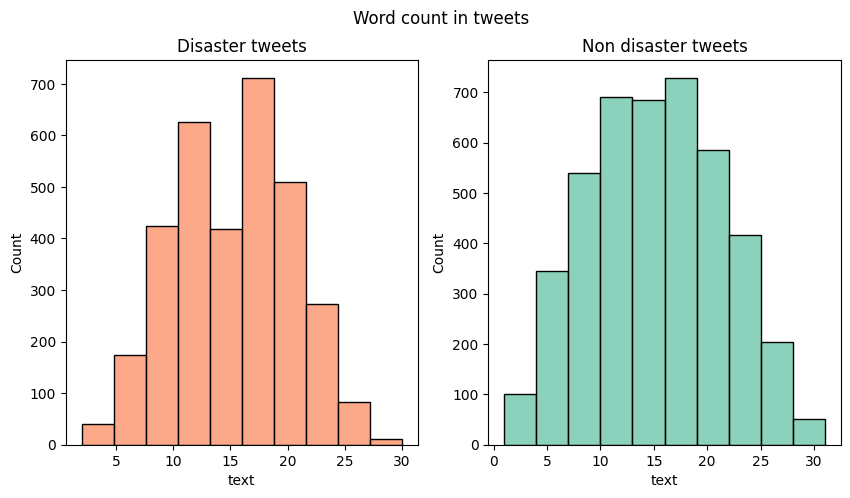

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len_disaster = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
tweet_len_non_disaster = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))

sns.histplot(tweet_len_disaster, ax=ax1, color=sns.color_palette()[1], bins=10) 
ax1.set_title('Disaster tweets')

sns.histplot(tweet_len_non_disaster, ax=ax2, color=sns.color_palette()[0], bins=10)
ax2.set_title('Non disaster tweets')

fig.suptitle('Word count in tweets')
plt.show()


TODO: experiment with feature engineering

In [80]:
# References:
# https://monkeylearn.com/blog/text-cleaning/
# https://stackoverflow.com/a/47091370
# https://stackoverflow.com/a/49146722


# Define function for text cleaning
def clean_text(text):
    #removal of url
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)

    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)

    # remove mentions
    text = re.sub('@\S+', '', text)
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)

    # Lowering all the words in text
    text = text.lower()

    return text

In [81]:
# Apply text cleaning to training and testing data
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [82]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)

In [83]:
# Define tokenization and padding parameters
vocab_size = 10000
embedding_dim = 32
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [84]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [85]:
# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            320000    
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 322177 (1.23 MB)
Trainable params: 322177 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [87]:
# Train the model
num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test),
                    verbose=2, callbacks=[early_stopping])

Epoch 1/10
191/191 - 3s - loss: 0.6714 - accuracy: 0.5747 - val_loss: 0.6262 - val_accuracy: 0.6546 - 3s/epoch - 17ms/step
Epoch 2/10
191/191 - 1s - loss: 0.5154 - accuracy: 0.7872 - val_loss: 0.4727 - val_accuracy: 0.7984 - 1s/epoch - 7ms/step
Epoch 3/10
191/191 - 1s - loss: 0.3731 - accuracy: 0.8484 - val_loss: 0.4615 - val_accuracy: 0.8063 - 1s/epoch - 7ms/step
Epoch 4/10
191/191 - 1s - loss: 0.2970 - accuracy: 0.8814 - val_loss: 0.4476 - val_accuracy: 0.8148 - 1s/epoch - 7ms/step
Epoch 5/10
191/191 - 1s - loss: 0.2423 - accuracy: 0.9108 - val_loss: 0.4675 - val_accuracy: 0.8083 - 1s/epoch - 6ms/step
Epoch 6/10
191/191 - 1s - loss: 0.2028 - accuracy: 0.9223 - val_loss: 0.4925 - val_accuracy: 0.7978 - 1s/epoch - 6ms/step
Epoch 7/10
191/191 - 1s - loss: 0.1698 - accuracy: 0.9374 - val_loss: 0.5346 - val_accuracy: 0.7853 - 1s/epoch - 5ms/step


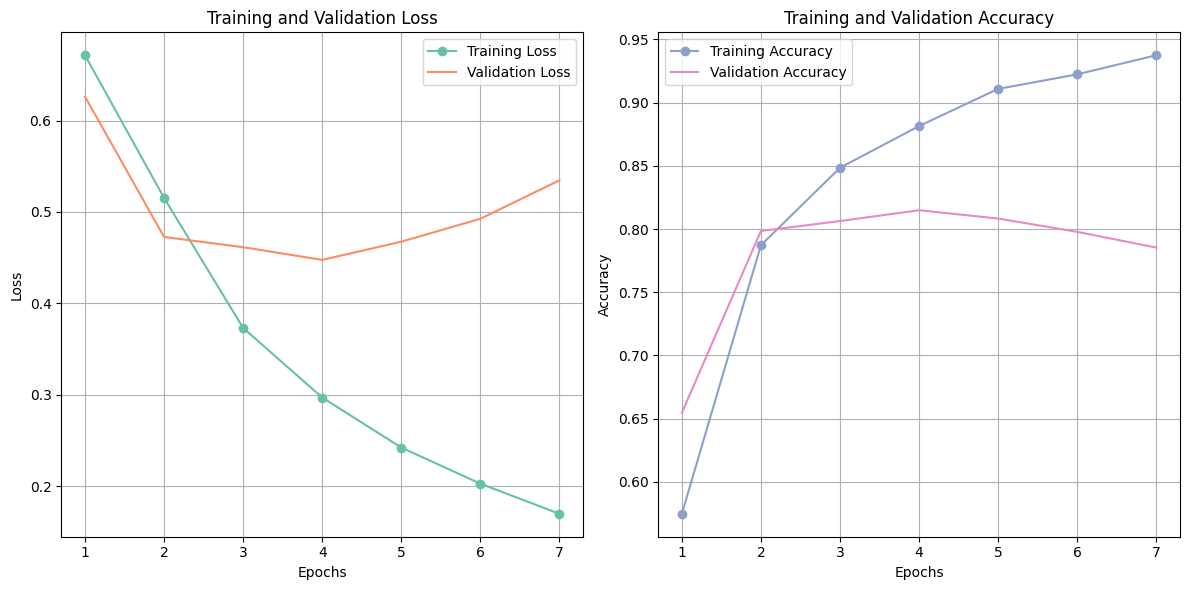

In [88]:
# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Get the current Seaborn palette's colors
colors = sns.color_palette()

# Number of epochs
epochs = range(1, len(training_loss) + 1)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot the Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, marker='o', color=colors[0], label='Training Loss')
plt.plot(epochs, validation_loss, color=colors[1], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot the Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, marker='o', color=colors[2], label='Training Accuracy')
plt.plot(epochs, validation_accuracy, color=colors[3], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [89]:
def plot_confusion_matrix_and_f1(y_true, y_pred, class_labels, title):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred)

    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title + ' -- F1 Score: ' + str(f1))
    plt.colorbar()

    # Add labels to the plot
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    # Label the cells with counts
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    plt.show()

48/48 [==============================] - 0s 1ms/step
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      3468
           1       0.93      0.87      0.90      2622

    accuracy                           0.92      6090
   macro avg       0.92      0.91      0.92      6090
weighted avg       0.92      0.92      0.92      6090

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       874
           1       0.81      0.74      0.77       649

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



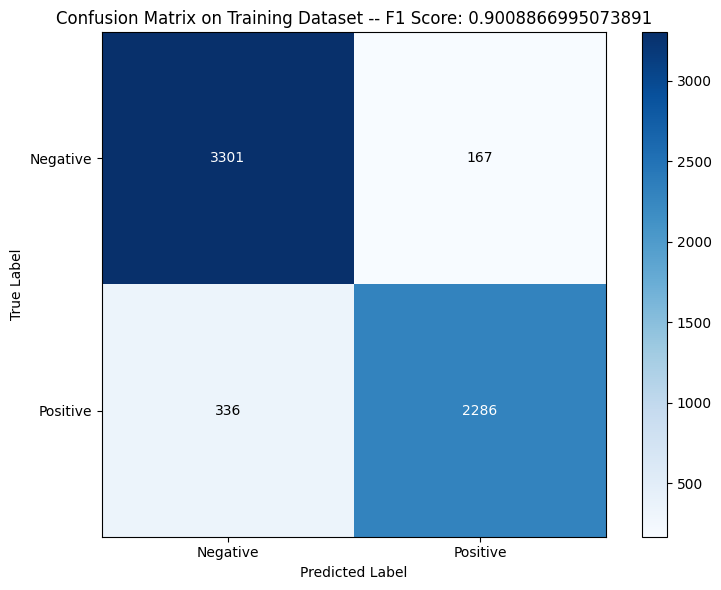

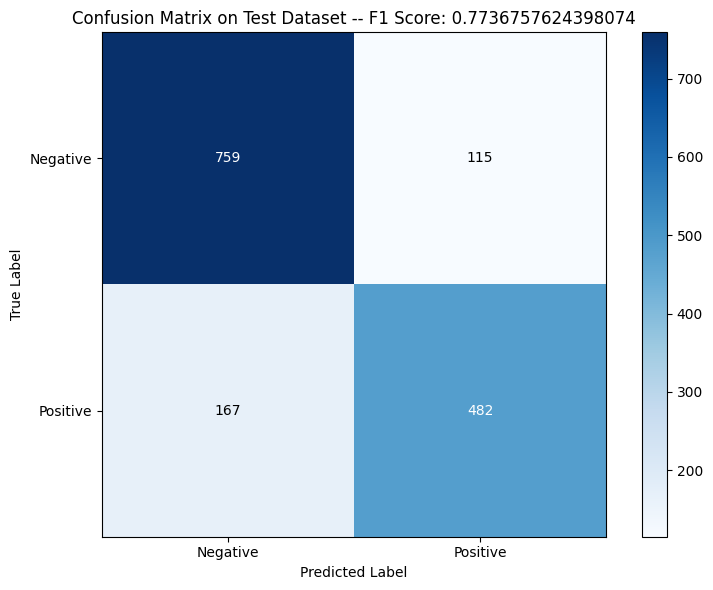

In [90]:
y_pred_train = model.predict(X_train_pad)
y_pred_train_binary = (y_pred_train > 0.5).astype(int)

y_pred_test = model.predict(X_test_pad)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)

report_train = classification_report(y_train, y_pred_train_binary)
report_test = classification_report(y_test, y_pred_test_binary)

print("Classification Report on Training Set:\n", report_train)
print("Classification Report on Test Set:\n", report_test)

class_labels = ['Negative', 'Positive']

# Training dataset
plot_confusion_matrix_and_f1(y_train, y_pred_train_binary, class_labels, 'Confusion Matrix on Training Dataset')

# Test dataset
plot_confusion_matrix_and_f1(y_test, y_pred_test_binary, class_labels, 'Confusion Matrix on Test Dataset')

In [91]:
# Prepare test data and make predictions
X_val = test['text']
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(X_val_pad)
binary_predictions = (predictions > 0.5).astype(int)

102/102 [==============================] - 0s 905us/step


In [92]:
# Generate submission file
def generate_submission(submission_file_path, predictions):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = predictions
    sample_submission.to_csv("../Data/Output/nn_submission.csv", index=False)

submission_file_path = "../Data/Input/sample_submission.csv"
generate_submission(submission_file_path, binary_predictions)